In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
all_data = pd.read_csv('/content/drive/MyDrive/datasets/ETH-USD.csv')
print(len(all_data))

1680


In [ ]:
all_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [ ]:
all_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1675,2022-06-11,1665.217896,1679.314209,1507.038940,1529.663452,1529.663452,21127089064
1676,2022-06-12,1530.189697,1539.705078,1436.183960,1445.216553,1445.216553,23465074882
1677,2022-06-13,1443.835449,1448.738037,1181.948242,1204.582764,1204.582764,45162788786
1678,2022-06-14,1204.555298,1252.471802,1094.701904,1211.662842,1211.662842,33327826525
1679,2022-06-15,1204.709473,1219.879272,1025.767456,1110.117432,1110.117432,28916948992


In [ ]:
df = all_data.reset_index()['Close']
df.head()

0    457.334015
1    424.440002
2    394.795990
3    408.903992
4    398.821014
Name: Close, dtype: float64

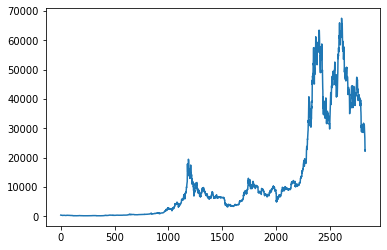

In [ ]:
plt.plot(df)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(np.array(df).reshape(-1,1))
print(scaled_df)

[[0.00414359]
 [0.00365546]
 [0.00321557]
 ...
 [0.33105368]
 [0.32688985]
 [0.33232172]]


In [ ]:
train_size = int(len(scaled_df)*.60)
validation_size = int(len(scaled_df)*.20)
test_size = len(df) - (train_size + validation_size)

print(f'Total train data: {train_size}, Validation size: {validation_size} and total test data: {test_size}')

Total train data: 1697, Validation size: 565 and total test data: 567


In [ ]:
train_data, validation_data, test_data = scaled_df[0: train_size], scaled_df[train_size:(train_size + validation_size)], scaled_df[(train_size + validation_size): len(scaled_df)]

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY=[], []
    
    for i in range(len(dataset)-time_step-1):
        a = dataset[i: (i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
  
    return np.array(dataX), np.array(dataY)

In [ ]:
def LSTM_run(time_step=7, lstm_unit = 64, _epocs=100, _batch_size=64):

    # make train-test for time series
    X_train, Y_train = create_dataset(train_data, time_step)
    X_validation, Y_validation = create_dataset(validation_data, time_step)
    X_test, Y_test = create_dataset(test_data, time_step)

    # re-shape for LSTM training
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_vlidation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

    # init model
    model = Sequential()
    model.add(LSTM(lstm_unit, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(LSTM(lstm_unit, return_sequences=True))
    model.add(LSTM(lstm_unit))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    print(model.summary())

    model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs=_epocs, batch_size=_batch_size, verbose=1)

    print('Model training end, start predicting...')

    train_predict = model.predict(X_train)

    #re-scale into previous scale
    train_predict_original = scaler.inverse_transform(train_predict)
    Y_train_original = scaler.inverse_transform(Y_train.reshape(-1,1))

    train_rsme = round(math.sqrt(mean_squared_error(Y_train_original, train_predict_original)), 4)
    print(f'Total train RSME= {train_rsme}')

    validation_predict = model.predict(X_validation)

    #re-scale into previous scale
    validation_predict_original = scaler.inverse_transform(validation_predict)
    Y_validation_original = scaler.inverse_transform(Y_validation.reshape(-1,1))

    validation_rsme = round(math.sqrt(mean_squared_error(Y_validation_original, validation_predict_original)), 4)
    print(f'Total validation RSME= {validation_rsme}')

    test_predict = model.predict(X_test)

    #re-scale into previous scale
    test_predict_original = scaler.inverse_transform(test_predict)
    Y_test_original = scaler.inverse_transform(Y_test.reshape(-1,1))

    test_rsme = round(math.sqrt(mean_squared_error(Y_test_original, test_predict_original)), 4)
    print(f'Total test RSME= {test_rsme}')

    new_train_predict = np.empty_like(df)
    new_train_predict[:]  = np.NaN
    new_train_predict[time_step:train_size-1] = train_predict_original.reshape(1,-1)

    new_validation_predict = np.empty_like(df)
    new_validation_predict[:]  = np.NaN
    new_validation_predict[(train_size+time_step) : (train_size+validation_size-1)] = validation_predict_original.reshape(1,-1)

    new_test_predict = np.empty_like(df)
    new_test_predict[:]  = np.NaN
    new_test_predict[(train_size+validation_size+time_step) : len(df)-1] = test_predict_original.reshape(1,-1)


    plt.plot(df)
    plt.plot(new_train_predict)
    plt.plot(new_validation_predict)
    plt.plot(new_test_predict)
    plt.show()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 7, 64)             16896     
                                                                 
 lstm_39 (LSTM)              (None, 64)                33024     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
27/27 [==============================] - 6s 42ms/step - loss: 0.0013 - val_loss: 1.5009e-04
Epoch 2/100
27/27 [==============================] - 0s 12ms/step - loss: 8.7546e-05 - val_loss: 9.1500e-05
Epoch 3/100
27/27 [==============================] - 0s 13ms/step - loss: 6.7641e-05 - val_loss:

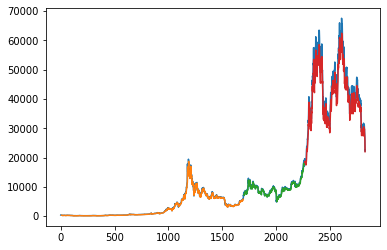

In [ ]:
LSTM_run(time_step=7, lstm_unit=64, _epocs=100, _batch_size=64)